<a href="https://colab.research.google.com/github/dadecampo/CVDeepLearning/blob/main/wGrapesFasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [997]:
import os
import cv2
import numpy as np
import torch
from PIL import Image
import glob
import torchvision.transforms as T
import torchvision
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from albumentations.core.composition import Compose
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn as nn
from albumentations.augmentations.geometric.transforms import HorizontalFlip
from albumentations.augmentations.geometric.rotate import Rotate
from albumentations.augmentations.crops.transforms import BBoxSafeRandomCrop
from albumentations.augmentations.transforms import HueSaturationValue
from albumentations.augmentations.transforms import ColorJitter, RandomBrightnessContrast

from albumentations.augmentations.geometric.resize import Resize
from albumentations.augmentations.geometric import Affine

from albumentations.augmentations.geometric.resize import RandomScale
import albumentations as A
import random

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 1
EPOCHS = 5
IMAGE_WIDTH = 1216
IMAGE_HEIGHT = 1216
FILES_DIR_WGISD = "dataset/wgisd/"
FILES_DIR_WGRAPE = "dataset/Calibrated_Images/"


def get_transform(train):
  if train:
    return Compose(
      [
        HorizontalFlip(p=0.5),
        RandomScale(scale_limit=0.4, interpolation = cv2.INTER_LINEAR, p=0.5),
        BBoxSafeRandomCrop(p=0.5),
        ColorJitter(random.uniform(0,0.2), random.uniform(0,0.2), random.uniform(0,0.2), random.uniform(0,0.2), p=0.5),
        ToTensorV2(p = 1.0) 
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )
  else:
    return Compose(
      [
        ToTensorV2(p=1.0)
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )


In [998]:

class GrapeDataset(torch.utils.data.Dataset):
    def __init__(self, root, width, height, transforms = None):
        self.transforms = transforms
        self.root = root
        self.no_size=False
        self.width =0
        self.height=0
        if(width==0 and height==0):
            self.no_size=True
        else:
            self.width = width
            self.height = height

        self.imgs=[]
        boxes_files=[]
        for root, dirs, files in os.walk(self.root):
            for file in files:
                if file.endswith(".txt") and not file.startswith("_counting"):
                    boxes_files.append(os.path.join(root, file))
                if file.endswith(".jpg") or file.endswith(".JPG")  :
                    self.imgs.append(os.path.join(root, file))
                if file.startswith("_counting"):
                   self.conting_file = os.path.join(root, "_counting.txt")
        self.imgs = sorted(self.imgs)
        boxes_files = sorted(boxes_files)
        self.boxes = boxes_files

    def __getitem__(self, idx):
        # get image and boxes
        img_path = self.imgs[idx]
        box_path = self.boxes[idx]
        # image elaboration
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        if not self.no_size:
            img = cv2.resize(img, (self.width, self.height), cv2.INTER_AREA)
        img /= 255.0

        height, width, _ = img.shape
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        labels=[]
        boxes=[]
        with open(box_path) as f:
            for line in f:
                labels.append(1)

                elems=[float(x) for x in line.split(' ')]

                x_center = int(elems[1] * width)
                y_center = int(elems[2] * height)
                box_wt = int(elems[3] * width)
                box_ht = int(elems[4] * height)

                x_min = max(0.0, x_center - box_wt/2)
                x_max  = min(width, x_center + box_wt/2)
                y_min = max(0.0, y_center - box_ht/2)
                y_max  = min(height, y_center + box_ht/2)

                boxes.append([x_min, y_min, x_max, y_max])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels= torch.as_tensor(labels, dtype=torch.int64)
        iscrowd= torch.zeros((boxes.shape[0],),dtype=torch.int64)
        area = (boxes[:,3]-boxes[:,1])*(boxes[:,2]-boxes[:,0])
        target={}
        target["boxes"] = boxes
        target["area"] = area
        target["labels"]= labels
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(image = img,
                                bboxes = target['boxes'],
                                labels = labels)
            img = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img, target

    def __len__(self):
        return len(self.imgs)



Number of Dataset Images:  300


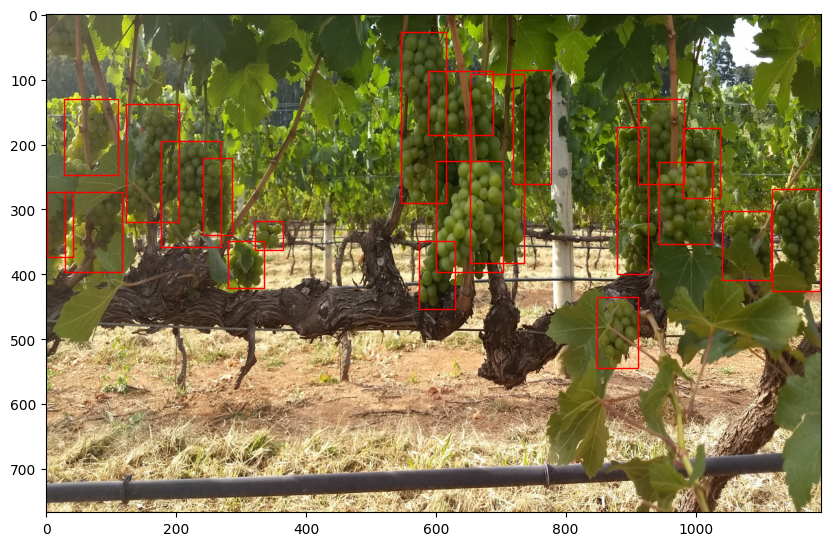

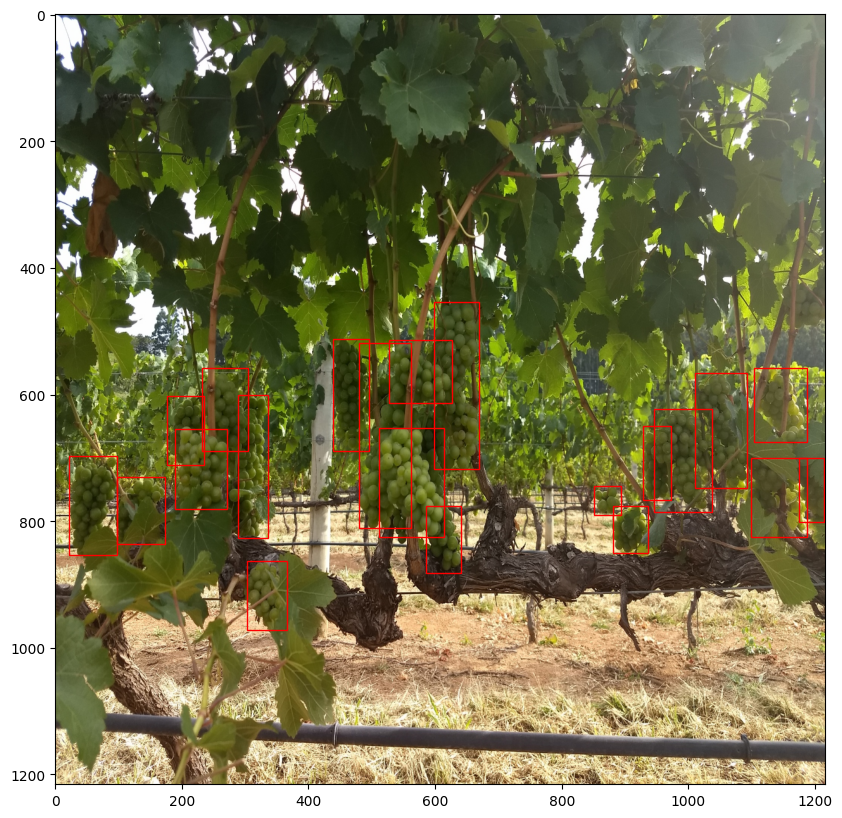

In [999]:
    
def plot_img_bbox(img, target, prediction):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
  fig, ax = plt.subplots(1,1)
  fig.set_size_inches(10,10)
  img=img.permute(1,2,0)
  ax.imshow(img)

  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'black',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    ax.add_patch(rect)

  for box in (prediction['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 1,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    ax.add_patch(rect)
  plt.show()

    
def plot_img_bbox_alone(img, target):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
  fig, ax = plt.subplots(1,1)
  fig.set_size_inches(10,10)
  img=img.permute(1,2,0)
  ax.imshow(img)

  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 1,
      edgecolor = 'red',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    ax.add_patch(rect)

  plt.show()
    
files_path=FILES_DIR_WGISD
dataset_train = GrapeDataset(files_path, IMAGE_WIDTH, IMAGE_HEIGHT, get_transform(train=True))
dataset_test = GrapeDataset(files_path, IMAGE_WIDTH, IMAGE_HEIGHT,  get_transform(train=False))
print("Number of Dataset Images: ", len(dataset_train))
n = random.randint(0,len(dataset_test)-1)
img, target = dataset_train[n]
plot_img_bbox_alone(img, target)
img, target = dataset_test[n]
plot_img_bbox_alone(img, target)

dataset_wgrape = GrapeDataset(FILES_DIR_WGRAPE, IMAGE_WIDTH, IMAGE_HEIGHT, transforms=get_transform(train=True))
dataset_test_wgrape = GrapeDataset(FILES_DIR_WGRAPE, IMAGE_WIDTH, IMAGE_HEIGHT,  transforms=get_transform(train=False))

dataset_wgisd = GrapeDataset(FILES_DIR_WGISD, IMAGE_WIDTH, IMAGE_HEIGHT, transforms=get_transform(train=True))
dataset_test_wgisd = GrapeDataset(FILES_DIR_WGISD, IMAGE_WIDTH, IMAGE_HEIGHT,  transforms=get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(random.randint(0,100))
indices = torch.randperm(len(dataset_wgrape)).tolist()

In [1000]:
from tqdm.notebook import tqdm 
import time
import torch
import numpy

loss_objectness = []
loss_box_reg = []
loss_classifier= []

def train_epoch(model, optimizer, data_loader, device, epoch):
        model.train()

        for i, (images, targets) in (tepoch := tqdm(enumerate(data_loader), unit="batch", total=len(data_loader))):
            tepoch.set_description(f"Epoch {epoch}")
            if len(targets)==0:
                  continue
            # Step 1: send the image to the required device.
            # Images is a list of B images (where B = batch_size of the DataLoader).
            images = list(img.to(device) for img in images)
            # Step 2: send each target to the required device
            # Targets is a dictionary of metadata. each (k,v) pair is a metadata
            # required for training.
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            model_time = time.time()
            loss_dict=model(images, targets)
            
            model_time = time.time() - model_time
            loss_objectness.append(loss_dict["loss_objectness"].cpu().detach().numpy())
            loss_box_reg.append(loss_dict["loss_box_reg"].cpu().detach().numpy())
            loss_classifier.append(loss_dict["loss_classifier"].cpu().detach().numpy())
            # Step 3. backward on loss.
            # Normally, you would obtain the loss from the model.forward()
            # and then just call .bacward() on it.
            # In this case, for each task, you have a different loss, due to
            # different error metrics adopted by the tasks.
            # One typical approach is to combine all the losses to one single loss,
            # and then then backward that single loss.
            # In this way you can adjust the weight of the different tasks,
            # multiplying each loss for a hyperparemeter.
            # E.G.:
            #       final_loss = loss_1 + gamma*(alpha*loss_2 + beta*loss_3)
            # In this case, we want to sum up all the losses.
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            tepoch.set_postfix(loss=losses.item())

In [1001]:
import detection.utils
import detection.transforms as T
# use our dataset and defined transformations
def redefine_dataset(path, size_image_width, size_image_height):
    dataset = GrapeDataset(path, size_image_width, size_image_height, transforms=get_transform(train=True))
    dataset_test = GrapeDataset(path, size_image_width, size_image_height,  transforms=get_transform(train=False))

    # train test split
    test_split = 0.2
    tsize = int(len(dataset)*test_split)
    dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])
    print(len(dataset))
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        collate_fn=detection.utils.collate_fn,
    )

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        collate_fn=detection.utils.collate_fn,
    )

    return data_loader, data_loader_test


data_loader_wgisd, data_loader_test_wgisd = redefine_dataset(FILES_DIR_WGISD, IMAGE_WIDTH, IMAGE_HEIGHT)
data_loader_wgrape, data_loader_test_wgrape = redefine_dataset(FILES_DIR_WGRAPE, IMAGE_WIDTH, IMAGE_HEIGHT)




209
216


In [1002]:
import torchvision.models.detection._utils as det_utils
import torch.nn.functional as F

class Custom_predictor(nn.Module):
    def __init__(self,in_channels,num_classes):
        super(Custom_predictor,self).__init__()
        self.additional_layer = nn.Linear(in_channels,1024) #this is the additional layer  
        self.additional_layer2 = nn.Linear(1024,in_channels) #this is the additional layer  

        self.cls_score = nn.Linear(in_channels, num_classes)
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4)
        
        
    def forward(self,x):
        if x.dim() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        x = self.additional_layer(x)
        x = F.relu(self.additional_layer2(x))

        scores = F.relu(self.cls_score(x))
        bbox_deltas = F.relu(self.bbox_pred(x))
        return scores, bbox_deltas
    
class CustomHead(nn.Module):
    def __init__(self,in_channels,roi_outshape,representation_size):
        super(CustomHead,self).__init__()
        
        self.conv = nn.Conv2d(in_channels,1024,kernel_size=3,padding=1)#this is teh additional layer adde
        #we will be sending a flattened layer, the size will eb in_channels*w*h, here roi_outshape represents it
        self.conv2 =nn.Conv2d(1024,in_channels,kernel_size=3,padding=1)
        self.fc6 = nn.Linear(in_channels*roi_outshape**2, representation_size)
        self.fc7 = nn.Linear(representation_size, representation_size)
        
    def forward(self,x):
       # breakpoint()
        
        x = self.conv(x)
        x = F.relu(self.conv2(x))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        return x
    

In [1003]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNConvFCHead
from torchvision.models.detection.faster_rcnn import RPNHead
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

def create_model_op(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    # get number of input features for the classifier
    in_channels = model.backbone.out_channels 
    roi_outshape = model.roi_heads.box_roi_pool.output_size[0]
    representation_size=model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_head  = CustomHead(in_channels,roi_outshape,representation_size)
    num_classes=2
    in_features = model.roi_heads.box_head.fc7.out_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = Custom_predictor(in_features,num_classes)
    return model

def create_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    # get number of input features for the classifier
    num_classes=2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
    return model
    

In [1004]:
import random
import os
import cv2
import numpy as np
import torch
from PIL import Image
import glob
import torchvision.transforms as T
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torchvision import transforms as torchtrans
from detection.engine import train_one_epoch, evaluate
import detection.utils
import detection.transforms as T
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models.detection import RetinaNet, RetinaNet_ResNet50_FPN_V2_Weights, FasterRCNN_ResNet50_FPN_Weights, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models import ResNet50_Weights, resnet101
from torchvision.models.detection.retinanet import RetinaNetClassificationHead, RetinaNetRegressionHead
from functools import partial
from tqdm.notebook import tqdm 
import gc

# train on gpu if available

num_classes = 2 # one class (class 0) is dedicated to the "background"
# lr_list=[0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003]
lr_list=[0.005]
coco_tests = []
metric_logger=[]
for lr in lr_list:
    # get the model using our helper function
    model = create_model(num_classes)
    #model = torch.load("weights/wgisd_frcnn.pth")
    
    # move model to the right device
    model.to(DEVICE)

    
    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    print(len(params))
    
    optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=lr*0.1)
    
    # and a learning rate scheduler which decreases the learning rate by
    # 10x every 3 epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        gamma=0.1,
        step_size=2
    )
    for epoch in range(EPOCHS):
        gc.collect()
        torch.cuda.empty_cache()
        # training for one epoch
        train_one_epoch(model, optimizer, data_loader_wgisd, DEVICE, epoch, 10)
        lr_scheduler.step()
        coco = evaluate(model, data_loader_test_wgisd, device=DEVICE)
        # evaluate on the test dataset
    
    #torch.save(model, "weights/wgisd_frcnn.pth")
    #for name, param in model.backbone.body.named_parameters():
    #    if 'layer2' in name:
    #        param.requires_grad_(False)
    #    if 'layer3' in name:
    #        param.requires_grad_(False)
#
    #params = [p for p in model.parameters() if p.requires_grad]
    #print(len(params))
    #optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=lr*0.1)
    ##
    ## and a learning rate scheduler which decreases the learning rate by
    ## 10x every 3 epochs
    #lr_scheduler = torch.optim.lr_scheduler.StepLR(
    #    optimizer,
    #    gamma=0.1,
    #    step_size=2
    #)
    #model.to(DEVICE)
#
    #for epoch in range(EPOCHS):
    #    gc.collect()
    #    torch.cuda.empty_cache()
    #    # training for one epoch
    #    train_one_epoch(model, optimizer, data_loader_wgrape, DEVICE, epoch, 10)
    #    lr_scheduler.step()
    #    coco = evaluate(model, data_loader_test_wgrape, device=DEVICE)
    #    # evaluate on the test dataset


    coco = evaluate(model, data_loader_test_wgrape, device=DEVICE)
    coco_tests.append(coco)


176
Epoch: [0]  [  0/209]  eta: 0:01:05  lr: 0.000029  loss: 2.4609 (2.4609)  loss_classifier: 0.9418 (0.9418)  loss_box_reg: 0.2596 (0.2596)  loss_objectness: 1.1444 (1.1444)  loss_rpn_box_reg: 0.1150 (0.1150)  time: 0.3140  data: 0.0450  max mem: 9123
Epoch: [0]  [ 10/209]  eta: 0:00:45  lr: 0.000269  loss: 2.2357 (2.2198)  loss_classifier: 0.8710 (0.8427)  loss_box_reg: 0.2596 (0.3213)  loss_objectness: 0.9474 (0.9582)  loss_rpn_box_reg: 0.1003 (0.0976)  time: 0.2310  data: 0.0996  max mem: 9123
Epoch: [0]  [ 20/209]  eta: 0:00:45  lr: 0.000509  loss: 1.9810 (1.9469)  loss_classifier: 0.6065 (0.6934)  loss_box_reg: 0.5036 (0.4960)  loss_objectness: 0.6247 (0.6630)  loss_rpn_box_reg: 0.0853 (0.0944)  time: 0.2375  data: 0.1228  max mem: 9123
Epoch: [0]  [ 30/209]  eta: 0:00:43  lr: 0.000749  loss: 1.5032 (1.7800)  loss_classifier: 0.5346 (0.6286)  loss_box_reg: 0.7062 (0.5785)  loss_objectness: 0.1273 (0.4846)  loss_rpn_box_reg: 0.0783 (0.0882)  time: 0.2458  data: 0.1313  max mem: 9

KeyboardInterrupt: 

In [1008]:
coco = evaluate(model, data_loader_test_wgisd, device=DEVICE)

creating index...
index created!
Test:  [ 0/60]  eta: 0:00:17  model_time: 0.2141 (0.2141)  evaluator_time: 0.0225 (0.0225)  time: 0.2906  data: 0.0480  max mem: 9123
Test:  [59/60]  eta: 0:00:00  model_time: 0.0420 (0.0457)  evaluator_time: 0.0080 (0.0112)  time: 0.0959  data: 0.0419  max mem: 9123
Test: Total time: 0:00:06 (0.1019 s / it)
Averaged stats: model_time: 0.0420 (0.0457)  evaluator_time: 0.0080 (0.0112)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.828
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.518
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.556
 Average Recall     (AR) @[ IoU=

In [1005]:
torch.save(model, "weights/frcnn.pth")

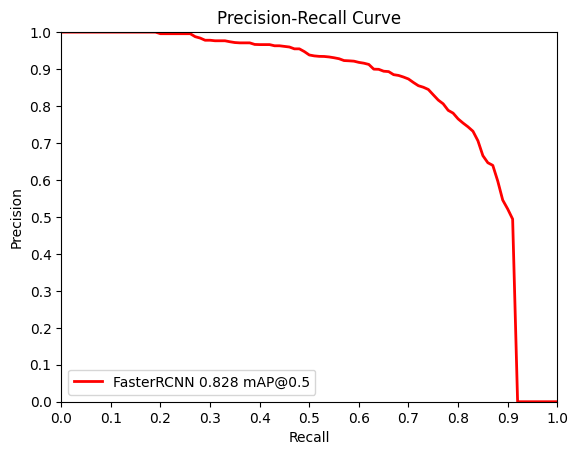

In [1009]:
#F1 = (2 * precision * recall)/(precision+recall)
for i in range(0,len(lr_list)):
    all_precision = coco.coco_eval['bbox'].eval['precision']
    map =coco.coco_eval['bbox'].stats[1]

    pr_5 = all_precision[0, :, 0, 0, 2] # data for IoU@0.5
    x = np.arange(0, 1.01, 0.01)
    plt.plot(x, pr_5, label="FasterRCNN "+str("{:.3f} mAP@0.5".format(map)), color="red", linewidth=2)

plt.legend(loc="best")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xticks(np.arange(0, 1.0001, 0.1))
plt.yticks(np.arange(0, 1.0001, 0.1))

plt.show()

# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.3):
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'].cpu(), orig_prediction['scores'].cpu(), iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'].cpu()[keep]
    final_prediction['scores'] = final_prediction['scores'].cpu()[keep]
    final_prediction['labels'] = final_prediction['labels'].cpu()[keep]
    
    return final_prediction

MODEL OUTPUT



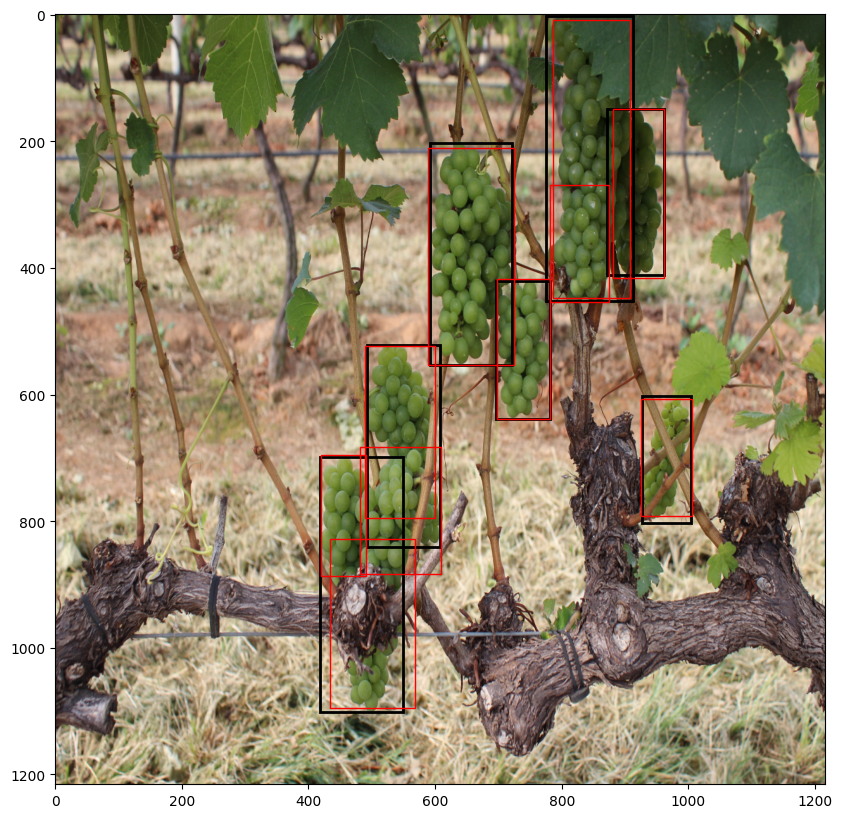

In [1012]:
img, target = dataset_test_wgisd[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(DEVICE)])[0]


print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.3)

plot_img_bbox(img, target, nms_prediction)